# notation
- $x$: $[n \times d]$ predictor
- $y$: $[n \times 1]$ response
- $(x_\textrm{train}, y_\textrm{train})$: train data
- $(x_\textrm{test}, y_\textrm{test})$: test data

# motivation
- assume a prior distribution over the response $y \sim \textrm{MVNormal}(0, \Sigma)$
    - each component of $y$ corresponds to one dimension of this multivariate distribution
    - $\Sigma(y_i, y_j)$ depends on the distance between $(x_i, x_j)$
    - $(x_i, x_j)$ are close -> correlation approaches $1$
    - $(x_i, x_j)$ are far -> correlation approaches $0$
- $y$ consists of some observard values $(y_\textrm{train})$ and some unobserved $(y_\textrm{test})$
    - what we're really interested in is the distribution $y_\textrm{test} | y_\textrm{train}$
    - in other words, we must condition the prior distribution $(y_\textrm{train}, y_\textrm{test})$ on $y_\textrm{train}$
    - conveniently, a MVNormal distribution after conditioning is still a MVNormal distribution (over the remaining variables)
- GPs as linear regression
    - assume we're fitting a liner model in some feature space $\phi$
    - we have a $N(0, \sigma^2)$ prior over the model weights
    - if we sample set of $x_i$, the $y_i$ have a joint $\text{MVNormal}(0, \Sigma)$ distribution
    - the choice of the feature space $\phi$ determines the covariance matrix $\Sigma$

# conditioning

Assume that $(y_\textrm{train}, y_\textrm{test})$ has the joint distribution:
$$p(y_\textrm{train}, y_\textrm{test}) = N\left(\begin{bmatrix} a \\ b \end{bmatrix}, \begin{bmatrix} A & B \\ B^T & C \end{bmatrix} \right)$$

Then the conditional distribution is:
$$p(y_\textrm{test} | y_\textrm{train}) = N(a + BC^{-1}(y_\textrm{train} - b), A - BC^{-1}B^T)$$

# distance measure (kernels)

- the covariance matrix $\Sigma$ is defined by the kernel, eg RBF, periodic, linear...
    - under RBF, the closer the points are in $L_2$, the higher their correlation
    - under a perodic kernel, the correlation does not monotonically depend on $L_2$ distance

# is it Bayesian?
- yes, although not in the classical sense
- typically, we assume a prior over parameters, then update the prior using a likelihood to get a posterior
- here, instead
    - the are no parameters (GPs are non-parametric)
    - we assume a prior joint distribution over $(y_\textrm{train}, y_\textrm{test})$
    - we condition the prior on $y_\textrm{train}$
    - the result is a distribution $y_\textrm{test} | y_\textrm{train}$

# Noisy observations
- assume that $f$ is a GP: $f \sim \text{GP}$
- our data has mean given by the GP plus some gaussian observation noise $\epsilon$: $y = f + \epsilon$
- *because* this likelihood is gaussian, we can work with it analytically --> just add an identity matrix to the covariance matrix of training data $A$
- if we leave the covariance matrix of test data unchanged, we are fitting the distribution of the mean of the test points; if the do add an identity matrix to the covariance matrix of the test points, we get the distribution for observations

# Reading
- [The Gradient](https://thegradient.pub/gaussian-process-not-quite-for-dummies/) (my favorite, nice overview of kernels)
- [Distill](https://distill.pub/2019/visual-exploration-gaussian-processes)
- [Gaussian processes with Jax in 80 lines](https://tpin.uk/posts/gaussian-processes-in-jax/)

Note: the entire notebook is based on [this article](https://thegradient.pub/gaussian-process-not-quite-for-dummies/) from *The Gradient*

# imports

In [1]:
import jax
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt

In [2]:
# use float64
from jax.config import config
config.update("jax_enable_x64", True)

# use high-resolution plots
%config InlineBackend.figure_format='retina'

# helper functions

In [3]:
def sample_mv_normal(key, mean, cov, shape, epsilon=1e-8):
    """
    like jax.random.multivariate_normal but with better numerical stability
    - when sampling from a multivariate normal, we have to perform cholesky decomposition of the covariance matrix
    - cholesky decomposition of a matrix requires that the matrix be positive definite
    - the RBF kernel is *strictly* positive definite but when we numerically approximate it,
      we might get tiny negative eigenvalues (ie its approximation is *not* positive definite)
    - to avoid numerical problems with the decomposition, it helps to add epsilon * identity matrix
    - based on: https://stats.stackexchange.com/a/386837/231402
    """
    z = jax.random.normal(key, shape=[*shape, *mean.shape])
    A = jnp.linalg.cholesky(cov + epsilon*jnp.eye(len(mean)))
    y = vmap(lambda z: A @ z + mean)(z)
    return y

# define kernels

In [17]:
def vectorize_kernel(kernel_fn):
    return vmap(vmap(kernel_fn, [None, 0]), [0, None])

@vectorize_kernel
def rbf_kernel(x1, x2):
    vertical_scale = 0.3
    horizontal_scale = 0.07
    d2 = ((x1 - x2)**2).sum()
    return vertical_scale**2 * jnp.exp(- 0.5 * d2 / horizontal_scale**2)

@vectorize_kernel
def laplace_kernel(x1, x2):
    vertical_scale = 0.3
    horizontal_scale = 0.6
    d = jnp.abs(x1 - x2).sum()
    return vertical_scale**2 * jnp.exp(- 0.5 * d / horizontal_scale**2)

@vectorize_kernel
def periodic_kernel(x1, x2):
    vertical_scale = 0.3
    horizontal_scale = 0.3
    period = 0.4
    d = jnp.sqrt(((x1 - x2)**2).sum())
    return vertical_scale**2 * jnp.exp(- 0.5 * jnp.sin(jnp.pi*d/period)**2 / horizontal_scale**2)

@vectorize_kernel
def linear_kernel(x1, x2):
    return jnp.dot(x1, x2)

In [16]:
# 2d test
x1 = jnp.ones([10, 2])
x2 = jnp.ones([20, 2])
kernel_fns = [rbf_kernel, laplace_kernel, periodic_kernel, linear_kernel]
for kernel_fn in kernel_fns:
    K = kernel_fn(x1, x2)
    print(K.shape)

(10, 20)
(10, 20)
(10, 20)
(10, 20)


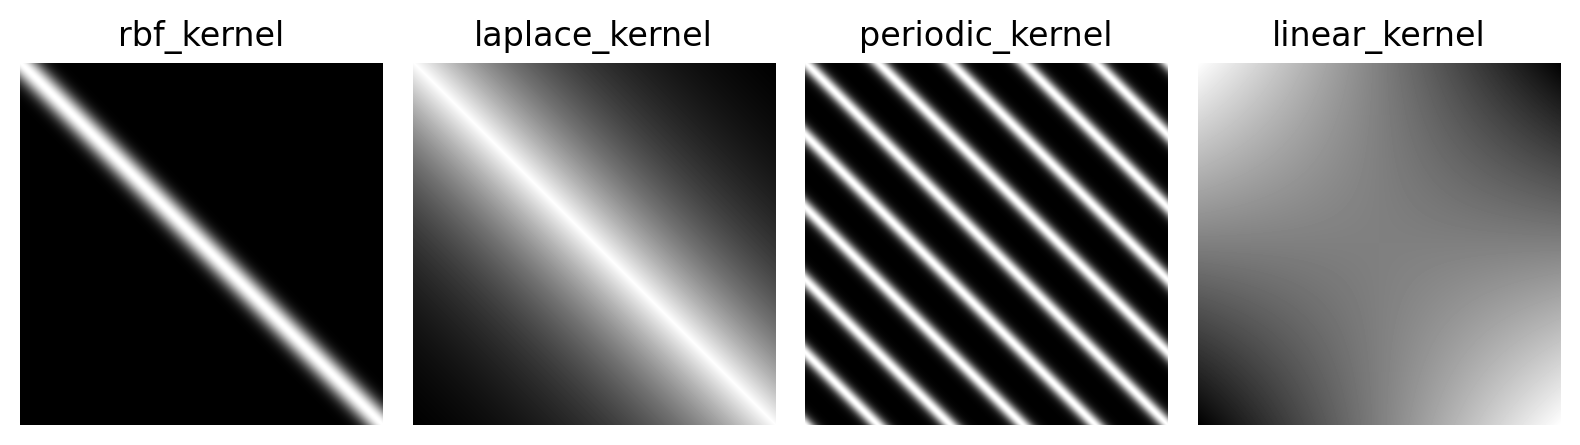

In [13]:
# plot kernel function
fig, axs = plt.subplots(1, 4, figsize=[8, 4])
x1 = jnp.linspace(-1, 1, 1_000)
x2 = jnp.linspace(-1, 1, 1_000)
kernel_fns = [rbf_kernel, laplace_kernel, periodic_kernel, linear_kernel]

for ax, kernel_fn in zip(axs, kernel_fns):
    ax.imshow(kernel_fn(x1, x2), cmap='gray')
    ax.set_title(kernel_fn.__name__)
    ax.axis('off')

plt.tight_layout()
plt.show()

# conditioning

In [6]:
def get_prior(x_test, kernel_fn):
    mean = jnp.zeros_like(x_test)
    cov = kernel_fn(x_test, x_test)
    return mean, cov

def get_posterior(x_train, x_test, y_train, kernel_fn, observation_noise_sd=0.05):
    A = kernel_fn(x_test, x_test)
    B = kernel_fn(x_test, x_train)
    C = kernel_fn(x_train, x_train) + observation_noise_sd**2 * jnp.eye(len(x_train))
    mean = B @ jnp.linalg.lstsq(C, y_train)[0]
    cov = A - B @ jnp.linalg.lstsq(C, B.T)[0]
    return mean, cov

# plots

In [7]:
def plot_gp(ax, x, mean, cov, samples):
    
    # plot mean ± sd
    sd = jnp.sqrt(cov.diagonal())
    ax.plot(x_test, mean)
    ax.fill_between(x_test, mean-2*sd, mean+2*sd, alpha=0.5)
    
    # plot samples
    for y_test in samples:
        ax.plot(x_test, y_test, c='black', ls='--', lw=1, alpha=0.7)

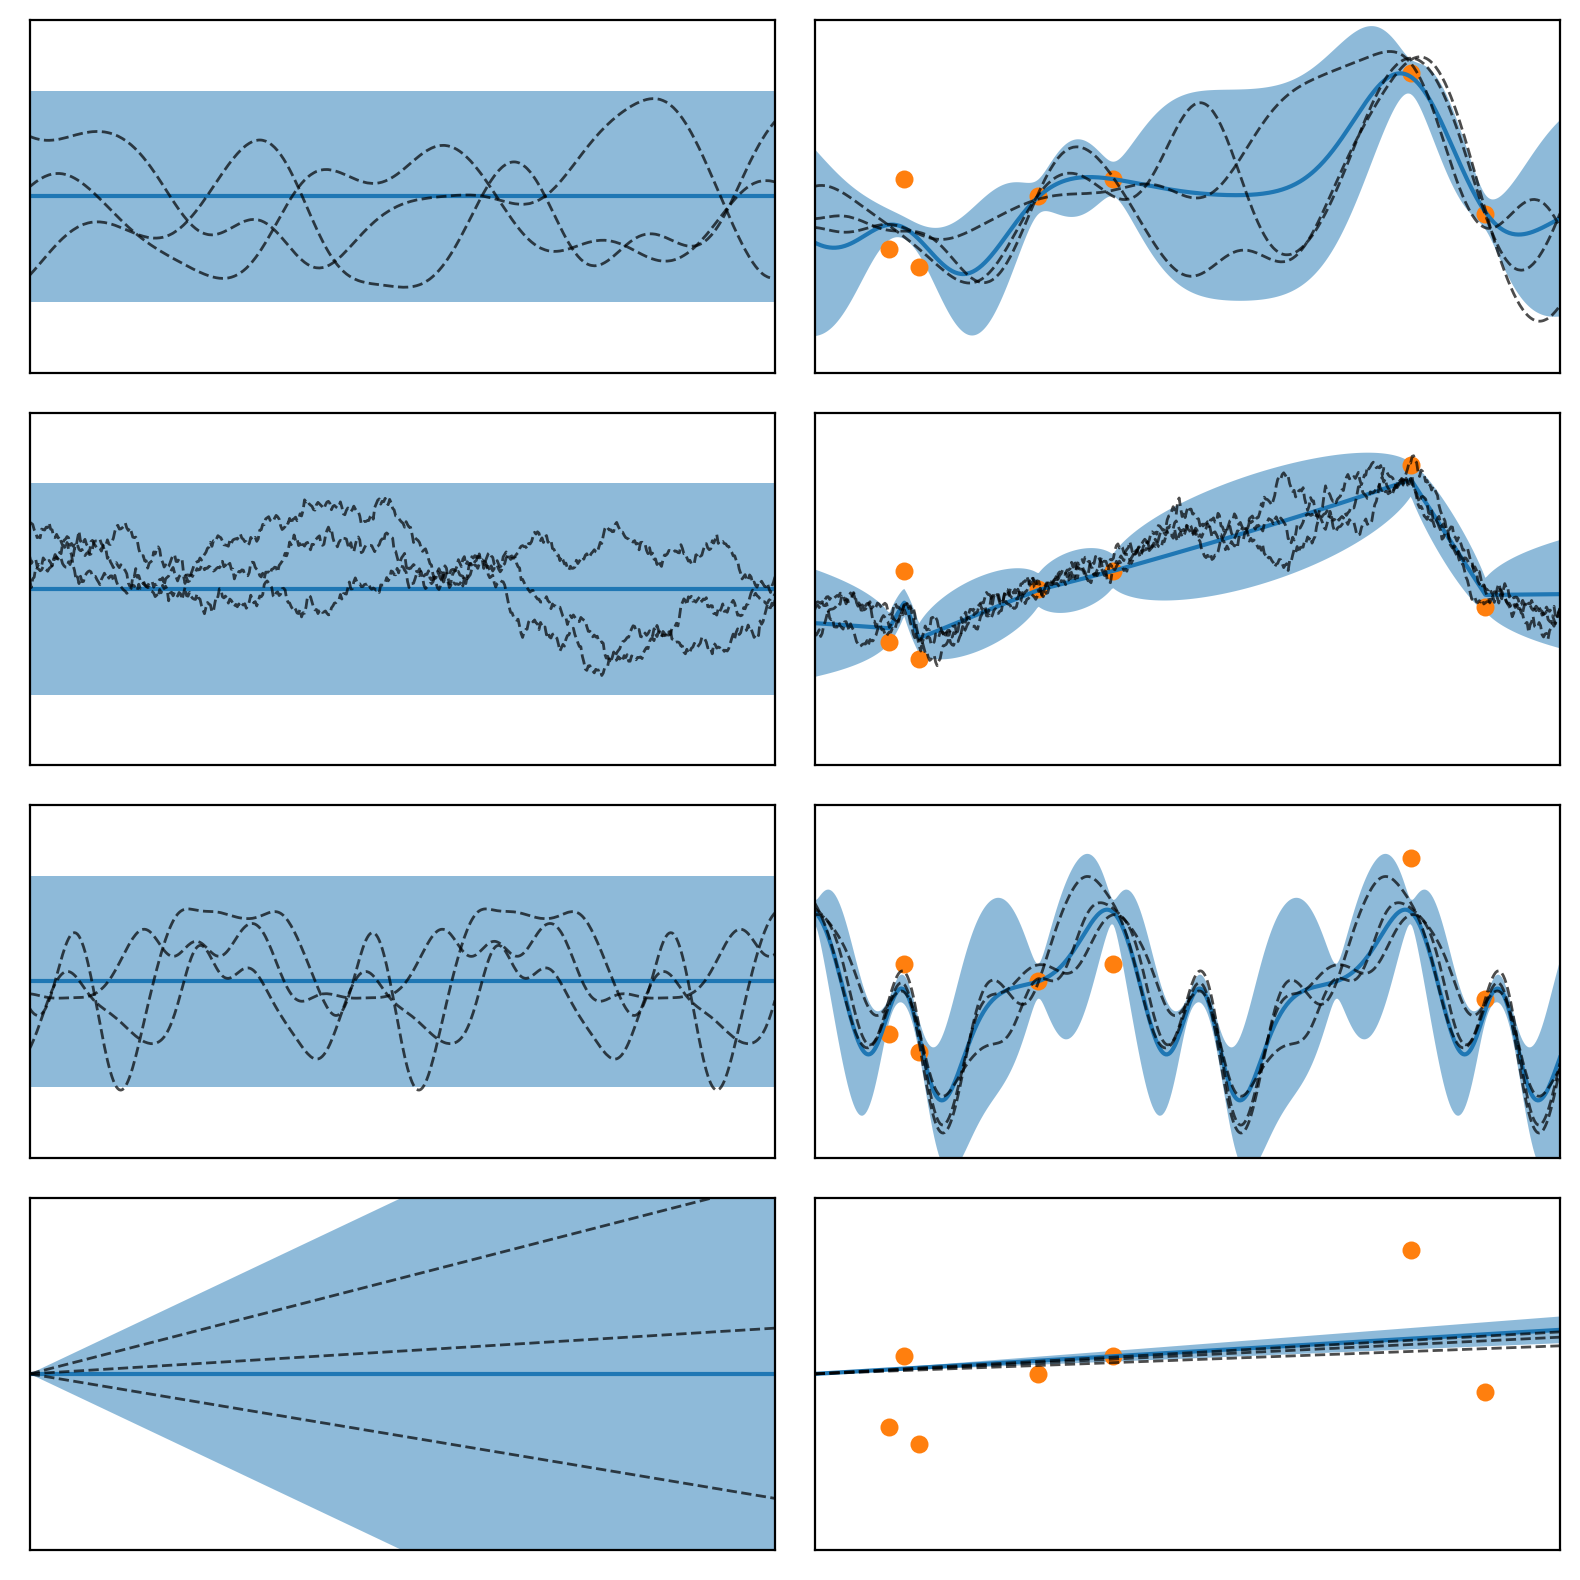

In [8]:
fig, axs = plt.subplots(len(kernel_fns), 2, figsize=[8, 8])

# set train and test data
x_train = jnp.array([ 0.10,  0.12,  0.14,  0.30,  0.40,  0.80,  0.90])
y_train = jnp.array([-0.30,  0.10, -0.40,  0.00,  0.10,  0.70, -0.10])
x_test = jnp.linspace(0, 1, 500)

# plot each kernel
key = jax.random.PRNGKey(2)
for i, kernel_fn in enumerate(kernel_fns):
    key, key_prior, key_posterior = jax.random.split(key, 3)
    
    # compute prior
    mean, cov = get_prior(x_test, kernel_fn)
    
    # sample prior
    samples = sample_mv_normal(key_prior, mean, cov, [3])
    
    # plot prior
    plot_gp(axs[i, 0], x_test, mean, cov, samples)
    
    # compute posterior by conditioning on observations
    mean, cov = get_posterior(x_train, x_test, y_train, kernel_fn)
    
    # sample posterior
    samples = sample_mv_normal(key_posterior, mean, cov, [3])

    # plot posterior
    plot_gp(axs[i, 1], x_test, mean, cov, samples)
    axs[i, 1].scatter(x_train, y_train, s=30)

# finish plot
for ax in axs.flatten():
    ax.set_xlim([0, 1])
    ax.set_ylim([-1, 1])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()